In [10]:

import pandas as pd
import sklearn as sk
from sklearn.model_selection import train_test_split
from sklearn.externals import joblib
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import numpy as np
#import autosklearn.regression
import time
import seaborn as sns



In [2]:

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
df = pd.read_hdf('../database/merged_v3_datetime_selected_10min.hd5','table')
df = df.dropna()




In [4]:
df['Speed 1 (rpm)'].describe()

count    9574.000000
mean       73.313767
std        10.537952
min         0.000000
25%        72.000000
50%        74.400000
75%        77.000000
max        83.700000
Name: Speed 1 (rpm), dtype: float64

In [5]:
l1_ = len(df)
df = df[df['Speed 1 (rpm)'] > 65]
df = df[df['Speed 1 (rpm)'] < 100]# Filter out all points <50 and >100 rpm.
l2_ = len(df)
print('Number of datapoints filtered out: ', l1_-l2_, ' relative, ', (l1_-l2_)/l1_)

Number of datapoints filtered out:  319  relative,  0.03331940672655108


In [6]:
features_all = list(df)
for i in range(len(features_all)):
    print(i,features_all[i])
    
label = features_all[1] # Consumpt 1 is for the ME
test_features = [features_all[11],features_all[9],features_all[10],features_all[7],features_all[0]] # Using Torque, Speed rpm
print('\nLabel: ', label)
print('Features: ', test_features)

0 Aux Power1 (kW)
1 Consump1 Rate (kg/h)
2 Consump2 Rate  (kg/h)
3 Eng1 Tot1 Mass (kg)
4 Eng1 Tot2 Mass (kg)
5 Eng2 Tot1 Mass (kg)
6 Eng2 Tot2 Mass (kg)
7 Gps Speed (kn)
8 Power1 (kW)
9 Speed 1 (rpm)
10 SpeedlogSpeed (kn)
11 Torque 1 (kNm)

Label:  Consump1 Rate (kg/h)
Features:  ['Torque 1 (kNm)', 'Speed 1 (rpm)', 'SpeedlogSpeed (kn)', 'Gps Speed (kn)', 'Aux Power1 (kW)']


In [7]:
# Create new dataframe for training
# Create new dataframe for training
df2 = pd.DataFrame()

for n_ in test_features:
    df2[n_] = df[n_]

df2[label] = df[label]

# I would suggest having some normalization here 
M = np.max(df2)
m = np.min(df2)
d = M-m 
mY = np.min(df2[label])
MY = np.max(df2[label])
dY = MY-mY
df3 = (df2-m)/d

def denormalize(data, m, d): 
    return (data*d)+m

# and then divide the dataset
train_dataset = df3.sample(frac=0.8,random_state=42)
test_dataset = df3.drop(train_dataset.index)

In [8]:
# Explain the data

from interpret import show
from interpret.data import Marginal

marginal = Marginal().explain_data(train_dataset[test_features], train_dataset[label], name = 'Train Data')
show(marginal)

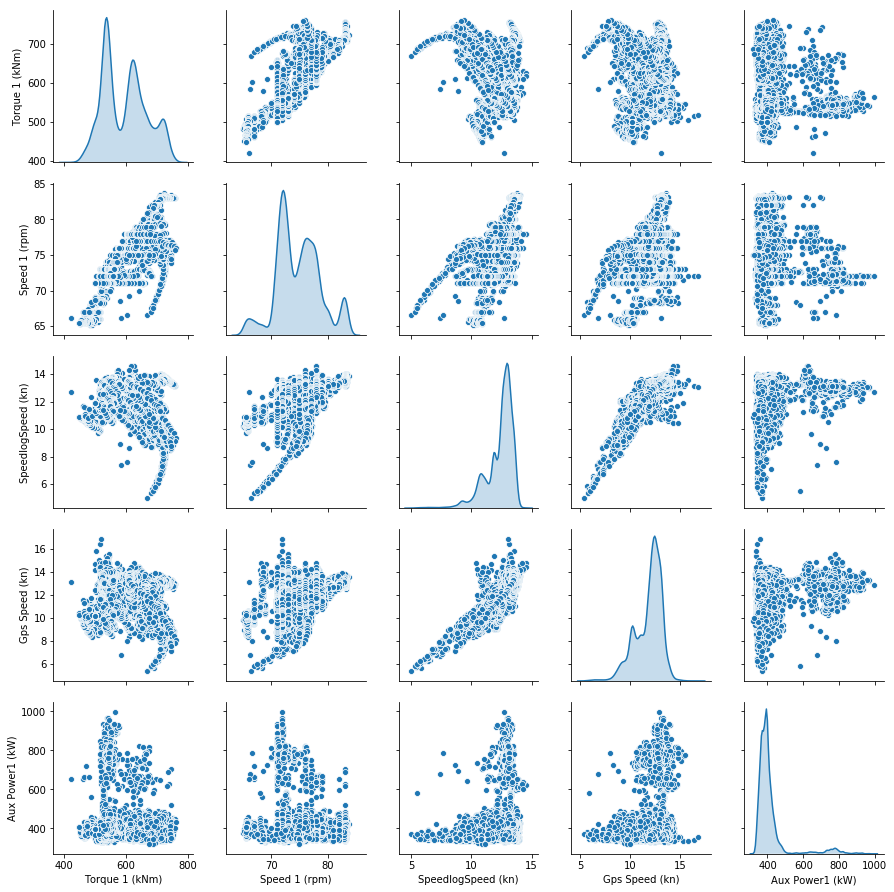

In [12]:
sns.pairplot(df[test_features], diag_kind="kde")

Linear R2 train: 0.8736980632815635
Mean absolute percentage error Linear 24.75885313914309 %


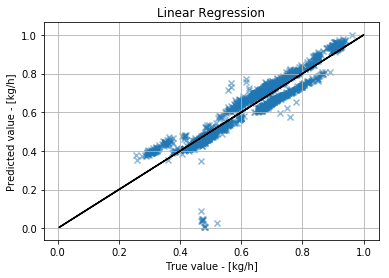

In [14]:
cores = -1

m_linear = sk.linear_model.LinearRegression(n_jobs=cores)
m_linear.fit(train_dataset[test_features], train_dataset[label])

R2_train = r2_score(m_linear.predict(test_dataset[test_features]),test_dataset[label])
print('Linear R2 train:', R2_train)


error = mean_absolute_percentage_error(test_dataset[label],m_linear.predict(test_dataset[test_features]))
print('Mean absolute percentage error Linear', error,'%')

plt.scatter(m_linear.predict(test_dataset[test_features]),test_dataset[label],marker='x',alpha=0.5)
plt.plot(test_dataset[label],test_dataset[label],color='black')
plt.title('Linear Regression')
plt.grid()

plt.xlabel('True value - [kg/h]')
plt.ylabel('Predicted value - [kg/h]')
plt.savefig('5_feat_linear_regr.ps')

/anaconda3/envs/tpot/lib/python3.6/site-packages/sklearn/svm/base.py:929: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



R2 train SVR: 0.8751651686853913
Mean absolute percentage error SVR 4.485872488144587 %


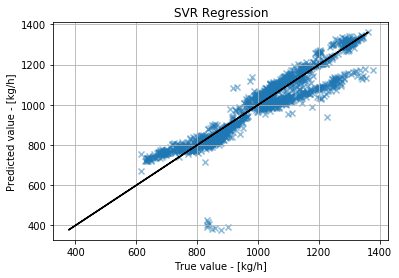

In [14]:

m_svr = sk.svm.LinearSVR(max_iter=50000)
m_svr.fit(train_dataset[test_features], train_dataset[label])

R2_train = r2_score(m_svr.predict(test_dataset[test_features]), test_dataset[label])
print('R2 train SVR:', R2_train)

error = mean_absolute_percentage_error(test_dataset[label],m_svr.predict(test_dataset[test_features]))
print('Mean absolute percentage error SVR', error,'%')

plt.scatter(m_svr.predict(test_dataset[test_features]),test_dataset[label],marker='x',alpha=0.5)
plt.plot(test_dataset[label],test_dataset[label],color='black')
plt.title('SVR Regression')

plt.grid()

plt.xlabel('True value - [kg/h]')
plt.ylabel('Predicted value - [kg/h]')
plt.savefig('5_feat_svr_regr.ps')


R2 train Ridge: 0.8751651686853913
Mean absolute percentage error Ridge 4.263476668060809 %


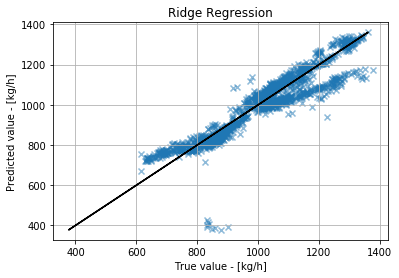

In [15]:
###sklearn.linear_model.Ridge(alpha=1.0, fit_intercept=True, 
#normalize=False, copy_X=True, max_iter=None, tol=0.001, solver=’auto’, 
#random_state=None)[source]¶

m_ridge = sk.linear_model.Ridge()
m_ridge.fit(train_dataset[test_features], train_dataset[label])

R2_train = r2_score(m_svr.predict(test_dataset[test_features]), test_dataset[label])
print('R2 train Ridge:', R2_train)

error = mean_absolute_percentage_error(test_dataset[label],m_ridge.predict(test_dataset[test_features]))
print('Mean absolute percentage error Ridge', error,'%')

plt.scatter(m_svr.predict(test_dataset[test_features]),test_dataset[label],marker='x',alpha=0.5)
plt.plot(test_dataset[label],test_dataset[label],color='black')
plt.title('Ridge Regression')

plt.grid()

plt.xlabel('True value - [kg/h]')
plt.ylabel('Predicted value - [kg/h]')
plt.savefig('5_feat_ridge_regr.ps')

In [16]:
###sklearn.linear_model.Ridge(alpha=1.0, fit_intercept=True, 
#normalize=False, copy_X=True, max_iter=None, tol=0.001, solver=’auto’, 
#random_state=None)[source]¶

X_train = train_dataset[test_features]
y_train = train_dataset[label]
#X_test = [[1,3],[2,5]]    

p = np.polyfit(train_dataset[label],train_dataset[test_features],2)

print(p)


[[ 1.62686986e-04  1.36629790e-05  3.42719955e-06  3.82163630e-06
  -7.90235802e-05]
 [ 8.32884990e-02 -6.10212279e-03 -6.00541368e-03 -6.73738554e-03
   5.84753900e-02]
 [ 3.56077068e+02  6.73711275e+01  1.48451473e+01  1.47027865e+01
   4.33555517e+02]]


In [18]:
x = np.array(train_dataset[test_features])[10]
print(x)

pred = x[0]**2 * p[0] * p[1] + p[1] + p[2]
print(pred)

[646.7   78.2   12.74  12.51 393.5 ]
[361.82723025  67.33015701  14.83053417  14.68528087 431.68142139]


R2 train random forest: 0.9676444213436507
Mean absolute percentage error RF 1.33994872520759 %


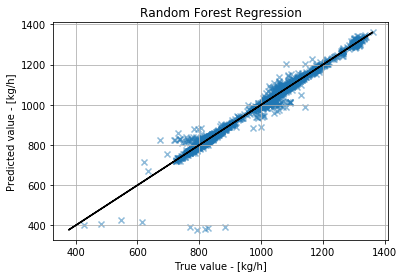

In [20]:

from sklearn.ensemble import RandomForestRegressor
m_rf = RandomForestRegressor(max_depth=100, random_state=42,n_estimators=500)

m_rf.fit(train_dataset[test_features], train_dataset[label])

R2_train = r2_score(m_rf.predict(test_dataset[test_features]),test_dataset[label])
print('R2 train random forest:', R2_train)

error = mean_absolute_percentage_error(test_dataset[label],m_rf.predict(test_dataset[test_features]))
print('Mean absolute percentage error RF', error,'%')

plt.scatter(m_rf.predict(test_dataset[test_features]),test_dataset[label],marker='x',alpha=0.5)
plt.plot(test_dataset[label],test_dataset[label],color='black')
plt.title('Random Forest Regression')

plt.grid()

plt.xlabel('True value - [kg/h]')
plt.ylabel('Predicted value - [kg/h]')
plt.savefig('5_feat_RF_regr.ps')


R2 train NN: 0.9676444213436507
Mean absolute percentage error NN 3.213790812767377 %


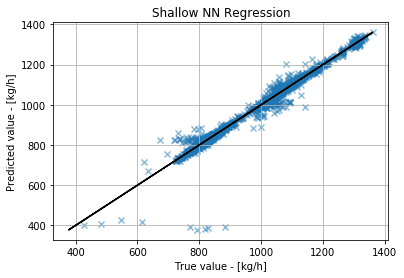

In [21]:
## Shallow NN

###sklearn.neural_network.MLPRegressor(hidden_layer_sizes=(100, ), activation=’relu’,
##solver=’adam’, alpha=0.0001, batch_size=’auto’, learning_rate=’constant’, learning_rate_init=0.001,
###power_t=0.5, max_iter=200, shuffle=True, random_state=None, tol=0.0001, verbose=False, warm_start=False,
##momentum=0.9, nesterovs_momentum=True, early_stopping=False, validation_fraction=0.1, beta_1=0.9, beta_2=0.999, 
##epsilon=1e-08, n_iter_no_change=10)[source]¶

from sklearn.neural_network import MLPRegressor
m_NN = MLPRegressor(hidden_layer_sizes=200, activation='relu',alpha=0.0001,max_iter=10000)
m_NN.fit(train_dataset[test_features], train_dataset[label])

R2_train = r2_score(m_rf.predict(test_dataset[test_features]),test_dataset[label])
print('R2 train NN:', R2_train)

error = mean_absolute_percentage_error(test_dataset[label],m_NN.predict(test_dataset[test_features]))
print('Mean absolute percentage error NN', error,'%')

plt.scatter(m_rf.predict(test_dataset[test_features]),test_dataset[label],marker='x',alpha=0.5)
plt.plot(test_dataset[label],test_dataset[label],color='black')
plt.title('Shallow NN Regression')

plt.grid()

plt.xlabel('True value - [kg/h]')
plt.ylabel('Predicted value - [kg/h]')
plt.savefig('5_feat_shallow_NN_regr.ps')

In [ ]:
from tpot import TPOTRegressor
m_tpot = TPOTRegressor(generations=20, population_size=50, verbosity=2, n_jobs=cores, scoring='r2')

m_tpot.fit(train_dataset[test_features], train_dataset[label])


Mean absolute percentage error 1.235365439141536 %
R2 train TPOT: 0.972125968966324


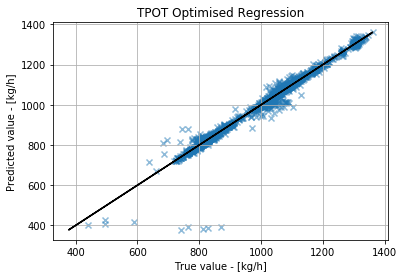

In [24]:
import numpy as np

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

error = mean_absolute_percentage_error(test_dataset[label],m_tpot.predict(test_dataset[test_features]))
print('Mean absolute percentage error', error,'%')

R2_train = r2_score(m_tpot.predict(test_dataset[test_features]),test_dataset[label])
print('R2 train TPOT:', R2_train)

plt.scatter(m_tpot.predict(test_dataset[test_features]),test_dataset[label],marker='x',alpha=0.5)
plt.plot(test_dataset[label],test_dataset[label],color='black')
plt.title('TPOT Optimised Regression')

plt.grid()

plt.xlabel('True value - [kg/h]')
plt.ylabel('Predicted value - [kg/h]')

plt.savefig('TPOT_regr.ps')

In [ ]:
m_tpot.export('tpot_best_pipeline.py') # export the best pipeline among the population

In [ ]:
%matplotlib inline

In [ ]:
no_ = 300
X = np.linspace(65,85,no_)
#print(X)
Y = np.linspace(450,750,no_)


#z = np.array([[0,0,0]])

z = np.empty([0,3])

for n_ in range(no_):   
    for i in range(no_):
        z = np.append(z, [ [X[n_],Y[i],float(m_tpot.predict( [[Y[n_],X[i]]] ) ) ]],axis=0)


In [ ]:
m_tpot.predict(z[:,1:])

In [ ]:
from mpl_toolkits import mplot3d
%matplotlib inline

X = z[:,0]
Y = z[:,1]
Z = z[:,2]

In [ ]:


fig = plt.figure()
ax = plt.axes(projection='3d')
#ax.contour3D(X, Y, Z, 50, cmap='binary')
ax.scatter3D(X, Y, Z, c=Z, cmap='Greens');


ax.set_xlabel('rpm')
ax.set_ylabel('Torque')
ax.set_zlabel('Fuel')
plt.savefig('blabla.pdf')

In [ ]:
z[50:150]

In [ ]:
df3 = pd.DataFrame()
df3['data'] = z
df3.to_excel('output_300.xlsx')

In [ ]:
np.zeros((300,2))

In [ ]:
m_tpot.predict(np.zeros((2,2)))

In [ ]:
plt.scatter(m_tpot.predict([X,Y]),m_tpot.predict[X,Y])

In [ ]:
m_tpot.predict( (np.array(test_dataset[test_features] )))

In [ ]:
np.array(test_dataset[test_features] )[0]

In [ ]:
m_linear.predict(np.array([1,1]).reshape(-1,))

In [ ]:
from interpret import show
from interpret.perf import RegressionPerf
from interpret.blackbox import MorrisSensitivity
from interpret.blackbox import PartialDependence


#Model to use..

blackbox_model = m_rf

X_test = np.array(test_dataset[test_features])
y_test = np.array(test_dataset[label])
X_train = np.array(train_dataset[test_features])
y_train = np.array(train_dataset[label])


blackbox_perf = RegressionPerf(blackbox_model.predict).explain_perf(X_test, y_test, name='RF model')

#

sensitivity = MorrisSensitivity(predict_fn=blackbox_model.predict, data=X_train)
sensitivity_global = sensitivity.explain_global(name="Global Sensitivity")


pdp = PartialDependence(predict_fn=blackbox_model.predict, data=X_train)
pdp_global = pdp.explain_global(name='Partial Dependence')

show([blackbox_perf, sensitivity_global, pdp_global])

In [ ]:

#Model to use..

blackbox_model = m_svr

X_test = np.array(test_dataset[test_features])
y_test = np.array(test_dataset[label])
X_train = np.array(train_dataset[test_features])
y_train = np.array(train_dataset[label])

blackbox_perf = RegressionPerf(blackbox_model.predict).explain_perf(X_test, y_test, name='SVR model')

#

sensitivity = MorrisSensitivity(predict_fn=blackbox_model.predict, data=X_train)
sensitivity_global = sensitivity.explain_global(name="Global Sensitivity")


pdp = PartialDependence(predict_fn=blackbox_model.predict, data=X_train)
pdp_global = pdp.explain_global(name='Partial Dependence')

show([blackbox_perf, sensitivity_global, pdp_global])

In [ ]:
cores = -1 # use all cores

m_linear = sk.linear_model.LinearRegression(n_jobs=cores)
m_linear.fit(X_train, y_train.reshape(-1,))

R2_train = r2_score(m_linear.predict(X_test),y_test)
print('Linear R2 train:', R2_train)

m_svr = sk.svm.LinearSVR()
m_svr.fit(X_train, y_train.reshape(-1,))

R2_train = r2_score(m_svr.predict(X_test),y_test)
print('R2 train SVR:', R2_train)


In [ ]:
from sklearn.ensemble import RandomForestRegressor
randfor_regr = RandomForestRegressor(max_depth=40, random_state=42,n_estimators=200)

randfor_regr.fit(X_train, y_train.reshape(-1,))

R2_train = r2_score(randfor_regr.predict(X_test),y_test)
print('R2 train random forest:', R2_train)


In [ ]:
plt.scatter(m_svr.predict(X),y)
plt.title('Support vector Regr')
##



In [ ]:
plt.scatter(m_linear.predict(X),y)
plt.title('Linear Regr')



In [ ]:
plt.scatter(randfor_regr.predict(X),y)
plt.title('Random forest Regr')


In [ ]:
# Seems like the predictions are going 

m_svr.predict(X).min()